# 02 - Exploratory Data Analysis: Macro / Industry Data

## Aurora Utensils Manufacturing (AUM)

This notebook performs EDA on macro and industry-level data from FRED to understand the relationship between Aurora's sales and broader economic indicators.

### Data Sources
- **IPMAN**: Industrial Production Index - Manufacturing (FRED)
- **AMTMVS**: Manufacturers' Shipments - Total Manufacturing (FRED)

### Objectives
1. Load and inspect macro data
2. Visualize trends and patterns
3. Compare with AUM monthly sales
4. Assess usefulness as forecasting features

---

## 1. Setup

In [1]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os
from scipy import stats

# Project imports
import sys
sys.path.insert(0, '../src')
from data.load_data import load_config, load_macro_ip_data, load_macro_msi_data

# Plot settings
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 11
sns.set_palette('husl')

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# Ensure output directories exist
os.makedirs('../reports/figures', exist_ok=True)

print("✓ Setup complete")
print(f"  Analysis date: {datetime.now().strftime('%Y-%m-%d %H:%M')}")

✓ Setup complete
  Analysis date: 2025-12-12 04:19


In [2]:
# Load configuration
config = load_config()

print("Configuration loaded:")
print(f"  IPMAN file: {config['data_paths']['macro_ip_raw']}")
print(f"  MSI file: {config['data_paths']['macro_msi_raw']}")

Configuration loaded:
  IPMAN file: data/external/ipman.csv
  MSI file: data/external/mfg_shipments.csv


In [3]:
# Load macro data
# NOTE: User must first download these files from FRED:
#   - IPMAN: https://fred.stlouisfed.org/series/IPMAN -> save as data/external/ipman.csv
#   - AMTMVS: https://fred.stlouisfed.org/series/AMTMVS -> save as data/external/mfg_shipments.csv

try:
    df_ip = load_macro_ip_data(config)
    print(f"\n✓ IPMAN loaded: {len(df_ip)} rows")
except FileNotFoundError:
    print("⚠ IPMAN file not found. Please download from FRED.")
    df_ip = None

try:
    df_msi = load_macro_msi_data(config)
    print(f"✓ MSI loaded: {len(df_msi)} rows")
except FileNotFoundError:
    print("⚠ MSI file not found. Please download from FRED.")
    df_msi = None

[load_macro_ip_data] Loaded 645 rows, date range: 1972-01-01 00:00:00 to 2025-09-01 00:00:00

✓ IPMAN loaded: 645 rows
[load_macro_msi_data] Loaded 405 rows, date range: 1992-01-01 00:00:00 to 2025-09-01 00:00:00
✓ MSI loaded: 405 rows


---
## 2. Overview

In [4]:
# IPMAN Overview
if df_ip is not None:
    print("=== INDUSTRIAL PRODUCTION INDEX (IPMAN) ===")
    print(f"\nShape: {df_ip.shape}")
    print(f"\nDate range: {df_ip['date'].min()} to {df_ip['date'].max()}")
    print(f"\nFirst 5 rows:")
    display(df_ip.head())
    print(f"\nInfo:")
    df_ip.info()
    print(f"\nStatistics:")
    display(df_ip.describe())

=== INDUSTRIAL PRODUCTION INDEX (IPMAN) ===

Shape: (645, 2)

Date range: 1972-01-01 00:00:00 to 2025-09-01 00:00:00

First 5 rows:


,date,ip_value
0,1972-01-01,36.0361
1,1972-02-01,36.3103
2,1972-03-01,36.5521
3,1972-04-01,36.9727
4,1972-05-01,37.0413



Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 645 entries, 0 to 644
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      645 non-null    datetime64[ns]
 1   ip_value  645 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 10.2 KB

Statistics:


,ip_value
count,645.000000
mean,75.110842
std,23.573592
min,35.360800
25%,50.720300
50%,84.830200
75%,97.773800
max,106.612500


In [5]:
# MSI Overview
if df_msi is not None:
    print("=== MANUFACTURERS' SHIPMENTS (AMTMVS) ===")
    print(f"\nShape: {df_msi.shape}")
    print(f"\nDate range: {df_msi['date'].min()} to {df_msi['date'].max()}")
    print(f"\nFirst 5 rows:")
    display(df_msi.head())
    print(f"\nInfo:")
    df_msi.info()
    print(f"\nStatistics:")
    display(df_msi.describe())

=== MANUFACTURERS' SHIPMENTS (AMTMVS) ===

Shape: (405, 2)

Date range: 1992-01-01 00:00:00 to 2025-09-01 00:00:00

First 5 rows:


,date,msi_value
0,1992-01-01,227721
1,1992-02-01,228860
2,1992-03-01,238604
3,1992-04-01,239877
4,1992-05-01,243732



Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 405 entries, 0 to 404
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       405 non-null    datetime64[ns]
 1   msi_value  405 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 6.5 KB

Statistics:


,msi_value
count,405.000000
mean,413489.207407
std,98826.411498
min,227721.000000
25%,329775.000000
50%,420568.000000
75%,479682.000000
max,608530.000000


In [6]:
# Filter to AUM sales window: 2016-01 to 2020-12
START_DATE = '2016-01-01'
END_DATE = '2020-12-31'

if df_ip is not None:
    df_ip_window = df_ip[(df_ip['date'] >= START_DATE) & (df_ip['date'] <= END_DATE)].copy()
    print(f"IPMAN in sales window: {len(df_ip_window)} months")
else:
    df_ip_window = None

if df_msi is not None:
    df_msi_window = df_msi[(df_msi['date'] >= START_DATE) & (df_msi['date'] <= END_DATE)].copy()
    print(f"MSI in sales window: {len(df_msi_window)} months")
else:
    df_msi_window = None

IPMAN in sales window: 60 months
MSI in sales window: 60 months


---
## 3. Visualization

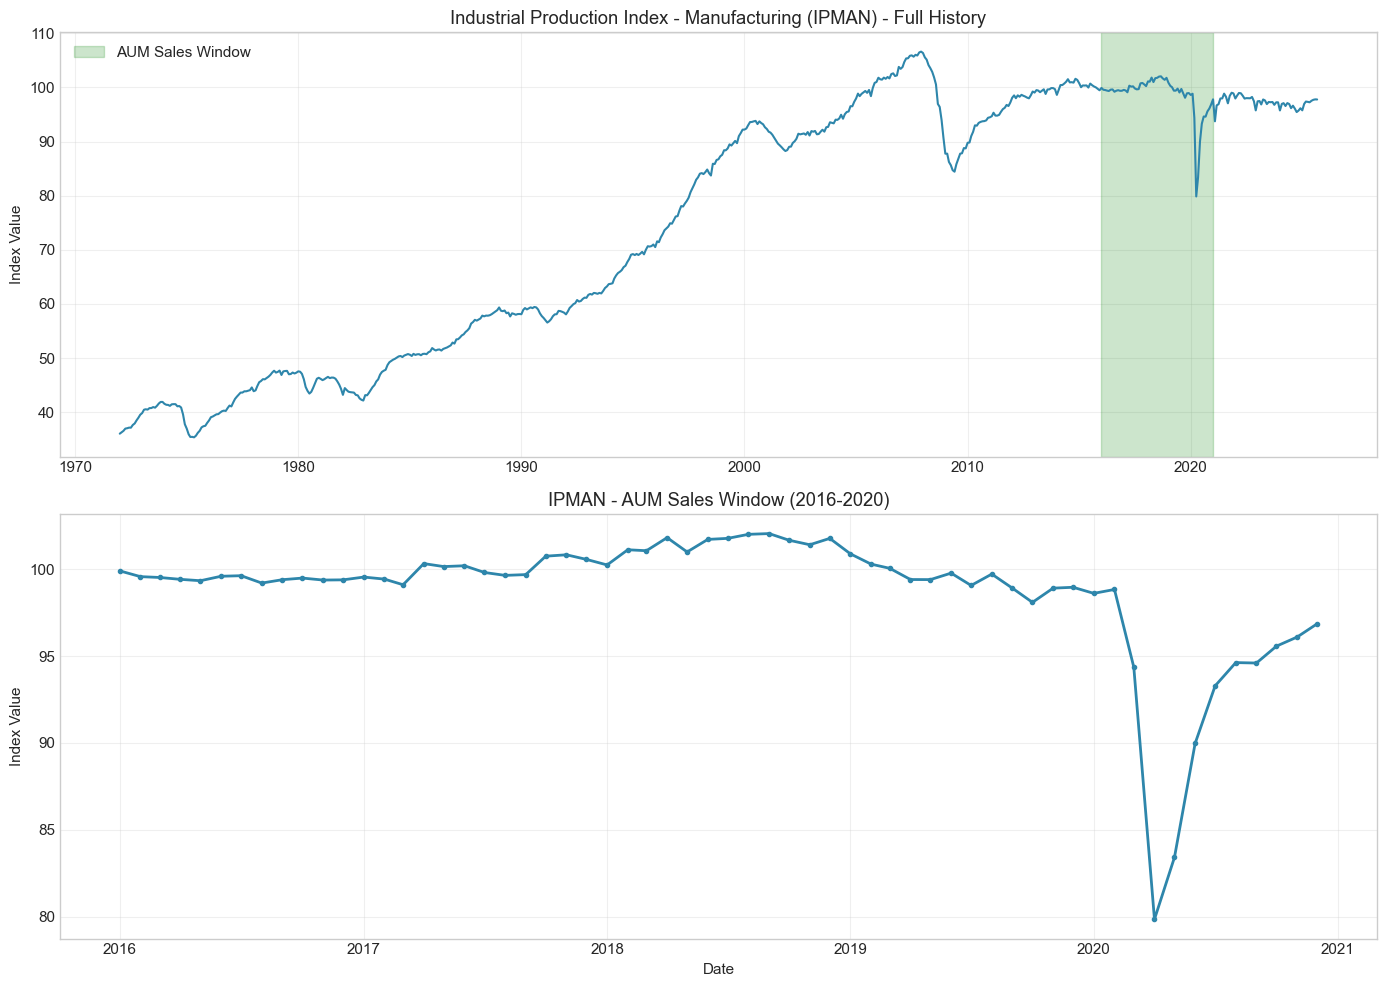

In [7]:
# Plot IPMAN - Full history
if df_ip is not None:
    fig, axes = plt.subplots(2, 1, figsize=(14, 10))
    
    # Full history
    axes[0].plot(df_ip['date'], df_ip['ip_value'], color='#2E86AB', linewidth=1.5)
    axes[0].set_title('Industrial Production Index - Manufacturing (IPMAN) - Full History')
    axes[0].set_ylabel('Index Value')
    axes[0].axvspan(pd.Timestamp(START_DATE), pd.Timestamp(END_DATE), alpha=0.2, color='green', label='AUM Sales Window')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # 2016-2020 window
    if df_ip_window is not None and len(df_ip_window) > 0:
        axes[1].plot(df_ip_window['date'], df_ip_window['ip_value'], color='#2E86AB', linewidth=2, marker='o', markersize=3)
        axes[1].set_title('IPMAN - AUM Sales Window (2016-2020)')
        axes[1].set_xlabel('Date')
        axes[1].set_ylabel('Index Value')
        axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../reports/figures/ipman_trend.png', dpi=150, bbox_inches='tight')
    plt.show()

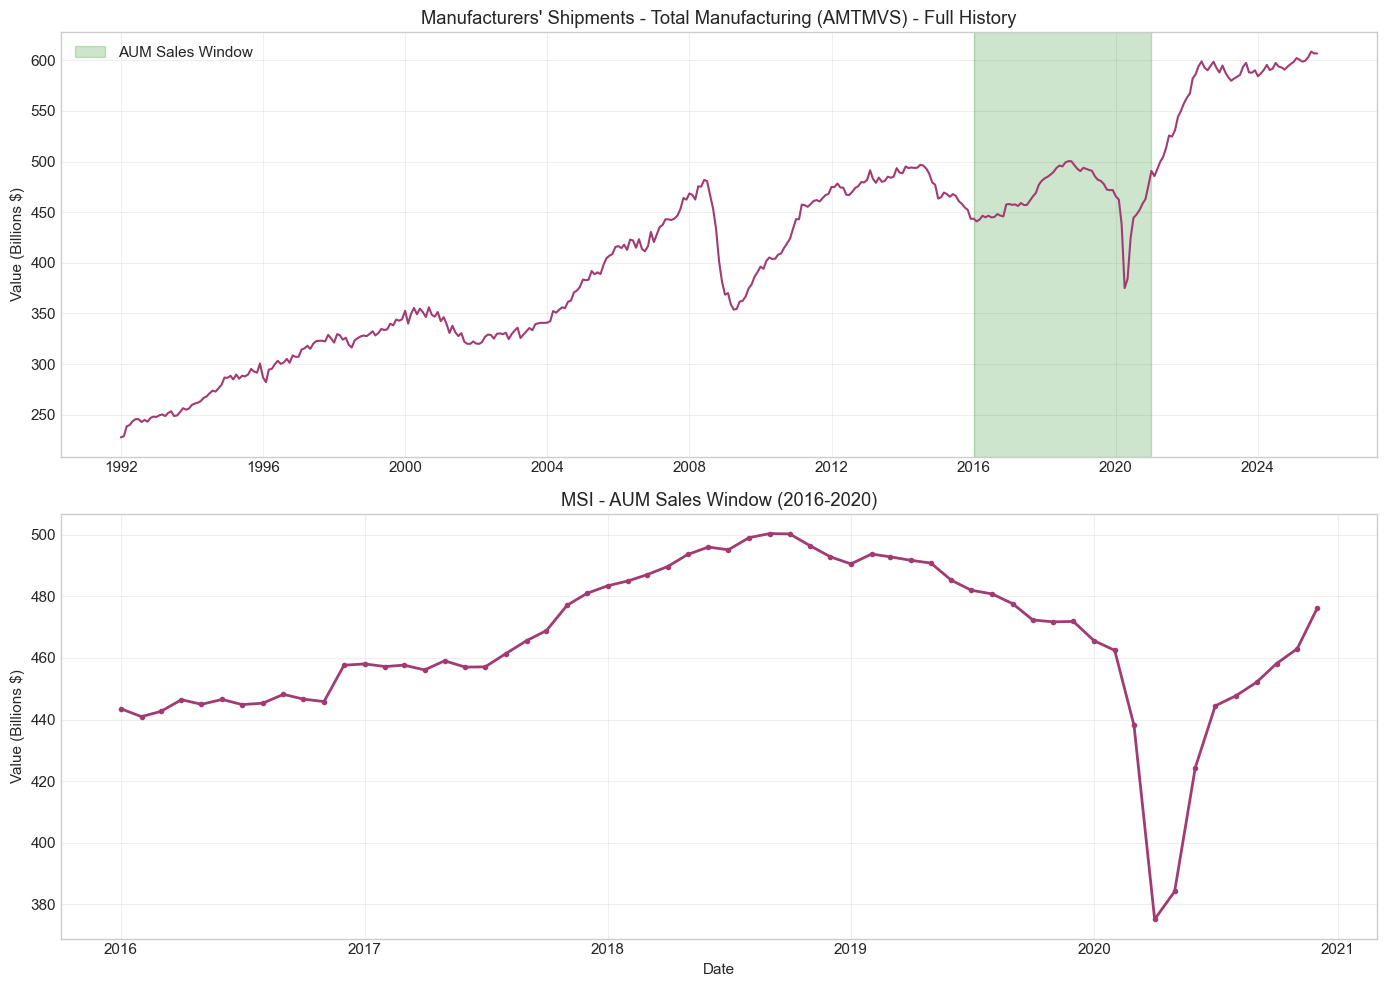

In [8]:
# Plot MSI - Full history
if df_msi is not None:
    fig, axes = plt.subplots(2, 1, figsize=(14, 10))
    
    # Full history
    axes[0].plot(df_msi['date'], df_msi['msi_value'] / 1e3, color='#A23B72', linewidth=1.5)
    axes[0].set_title("Manufacturers' Shipments - Total Manufacturing (AMTMVS) - Full History")
    axes[0].set_ylabel('Value (Billions $)')
    axes[0].axvspan(pd.Timestamp(START_DATE), pd.Timestamp(END_DATE), alpha=0.2, color='green', label='AUM Sales Window')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # 2016-2020 window
    if df_msi_window is not None and len(df_msi_window) > 0:
        axes[1].plot(df_msi_window['date'], df_msi_window['msi_value'] / 1e3, color='#A23B72', linewidth=2, marker='o', markersize=3)
        axes[1].set_title('MSI - AUM Sales Window (2016-2020)')
        axes[1].set_xlabel('Date')
        axes[1].set_ylabel('Value (Billions $)')
        axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../reports/figures/msi_trend.png', dpi=150, bbox_inches='tight')
    plt.show()

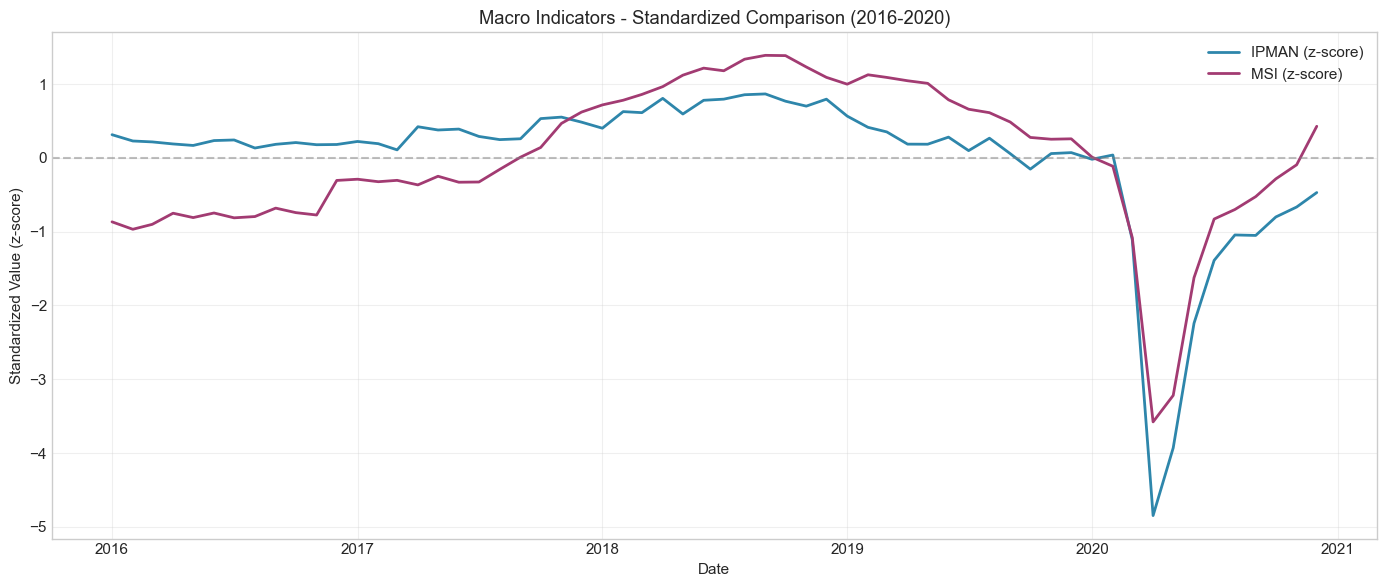

In [9]:
# Standardized comparison (z-score)
if df_ip_window is not None and df_msi_window is not None and len(df_ip_window) > 0 and len(df_msi_window) > 0:
    # Standardize both series
    ip_zscore = stats.zscore(df_ip_window['ip_value'])
    msi_zscore = stats.zscore(df_msi_window['msi_value'])
    
    plt.figure(figsize=(14, 6))
    plt.plot(df_ip_window['date'], ip_zscore, label='IPMAN (z-score)', color='#2E86AB', linewidth=2)
    plt.plot(df_msi_window['date'], msi_zscore, label='MSI (z-score)', color='#A23B72', linewidth=2)
    plt.axhline(0, color='gray', linestyle='--', alpha=0.5)
    plt.xlabel('Date')
    plt.ylabel('Standardized Value (z-score)')
    plt.title('Macro Indicators - Standardized Comparison (2016-2020)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('../reports/figures/macro_comparison_zscore.png', dpi=150, bbox_inches='tight')
    plt.show()

---
## 4. Relationship to AUM Monthly Sales

In [10]:
# Load AUM monthly sales
df_monthly = pd.read_csv('../data/interim/monthly_sales.csv')
df_monthly['year_month'] = pd.to_datetime(df_monthly['year_month'])
df_monthly['date'] = df_monthly['year_month'].dt.to_timestamp() if hasattr(df_monthly['year_month'].dt, 'to_timestamp') else df_monthly['year_month']

print(f"AUM Monthly Sales: {len(df_monthly)} rows")
print(f"Date range: {df_monthly['date'].min()} to {df_monthly['date'].max()}")
df_monthly.head()

AUM Monthly Sales: 60 rows
Date range: 2016-01-01 00:00:00 to 2020-12-01 00:00:00


,year_month,total_revenue,total_quantity,transaction_count,date,year,month
0,2016-01-01,46886250.0,187545,6200,2016-01-01,2016,1
1,2016-02-01,49299000.0,197196,5800,2016-02-01,2016,2
2,2016-03-01,63637250.0,254549,6200,2016-03-01,2016,3
3,2016-04-01,70358750.0,281435,6000,2016-04-01,2016,4
4,2016-05-01,78636000.0,314544,6200,2016-05-01,2016,5


In [11]:
# Merge with macro data
if df_ip_window is not None and len(df_ip_window) > 0:
    # Create year_month key for merging
    df_ip_window['year_month'] = df_ip_window['date'].dt.to_period('M')
    df_monthly['year_month_period'] = df_monthly['date'].dt.to_period('M')
    
    df_merged_ip = df_monthly.merge(
        df_ip_window[['year_month', 'ip_value']], 
        left_on='year_month_period', 
        right_on='year_month', 
        how='inner'
    )
    print(f"Merged with IPMAN: {len(df_merged_ip)} rows")
else:
    df_merged_ip = None

if df_msi_window is not None and len(df_msi_window) > 0:
    df_msi_window['year_month'] = df_msi_window['date'].dt.to_period('M')
    if 'year_month_period' not in df_monthly.columns:
        df_monthly['year_month_period'] = df_monthly['date'].dt.to_period('M')
    
    df_merged_msi = df_monthly.merge(
        df_msi_window[['year_month', 'msi_value']], 
        left_on='year_month_period', 
        right_on='year_month', 
        how='inner'
    )
    print(f"Merged with MSI: {len(df_merged_msi)} rows")
else:
    df_merged_msi = None

Merged with IPMAN: 60 rows
Merged with MSI: 60 rows


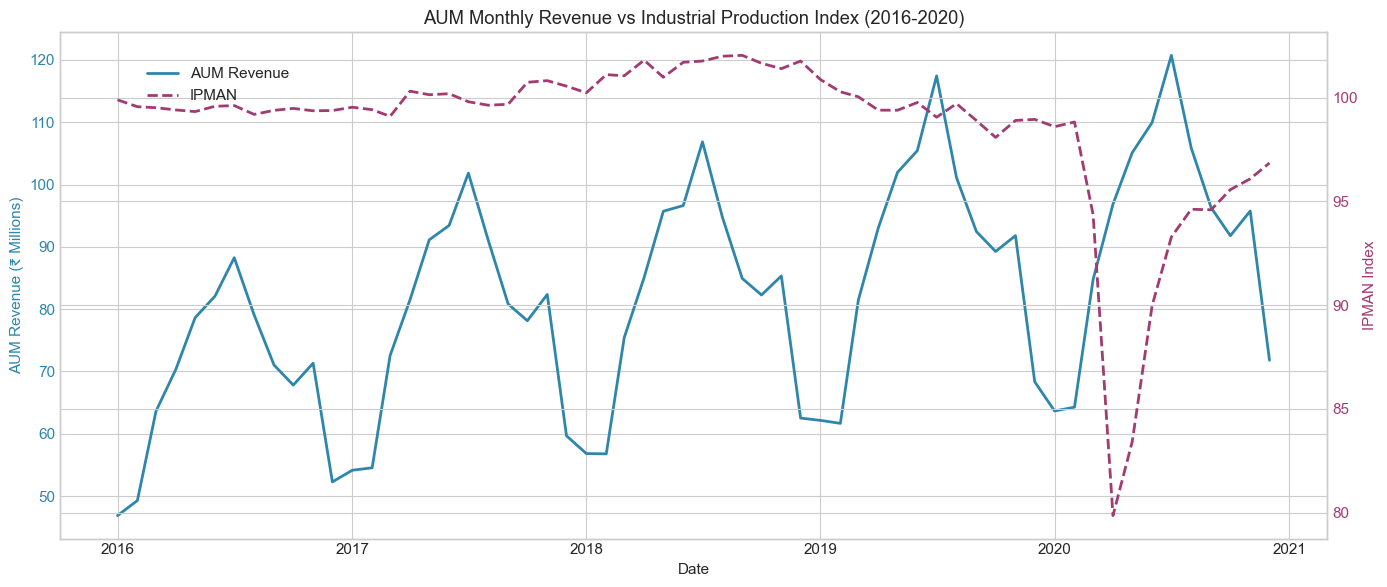

In [12]:
# Plot AUM revenue vs IPMAN
if df_merged_ip is not None and len(df_merged_ip) > 0:
    fig, ax1 = plt.subplots(figsize=(14, 6))
    
    ax1.set_xlabel('Date')
    ax1.set_ylabel('AUM Revenue (₹ Millions)', color='#2E86AB')
    ax1.plot(df_merged_ip['date'], df_merged_ip['total_revenue'] / 1e6, color='#2E86AB', linewidth=2, label='AUM Revenue')
    ax1.tick_params(axis='y', labelcolor='#2E86AB')
    
    ax2 = ax1.twinx()
    ax2.set_ylabel('IPMAN Index', color='#A23B72')
    ax2.plot(df_merged_ip['date'], df_merged_ip['ip_value'], color='#A23B72', linewidth=2, linestyle='--', label='IPMAN')
    ax2.tick_params(axis='y', labelcolor='#A23B72')
    
    plt.title('AUM Monthly Revenue vs Industrial Production Index (2016-2020)')
    fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
    plt.tight_layout()
    plt.savefig('../reports/figures/aum_vs_ipman.png', dpi=150, bbox_inches='tight')
    plt.show()

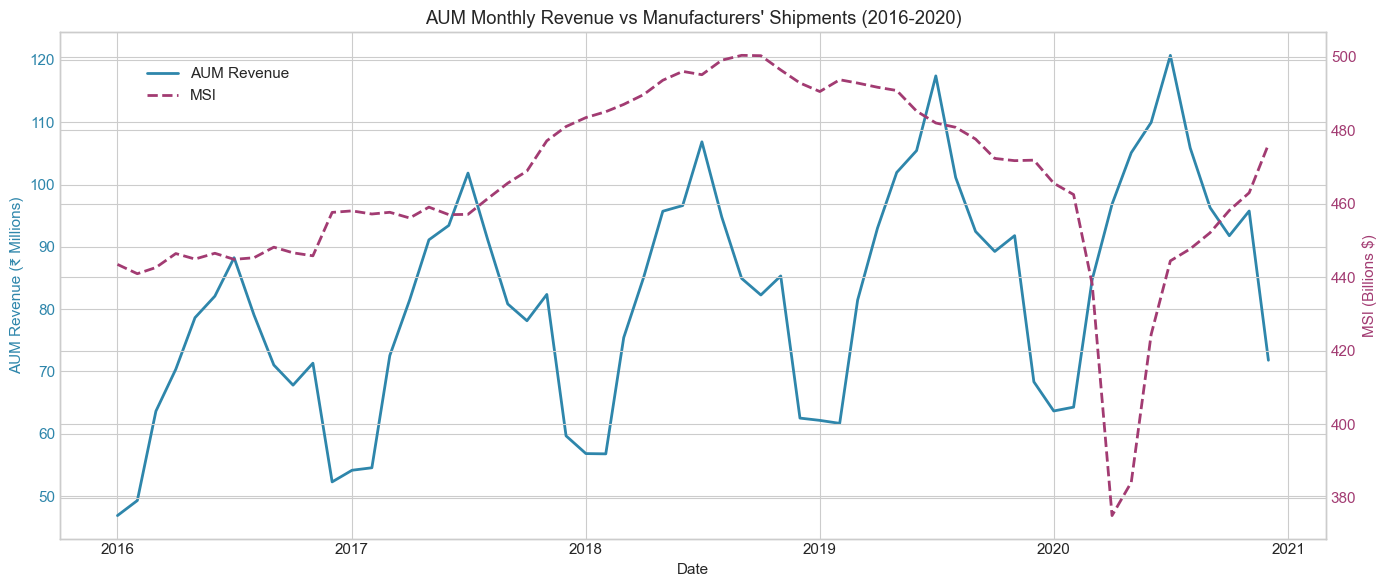

In [13]:
# Plot AUM revenue vs MSI
if df_merged_msi is not None and len(df_merged_msi) > 0:
    fig, ax1 = plt.subplots(figsize=(14, 6))
    
    ax1.set_xlabel('Date')
    ax1.set_ylabel('AUM Revenue (₹ Millions)', color='#2E86AB')
    ax1.plot(df_merged_msi['date'], df_merged_msi['total_revenue'] / 1e6, color='#2E86AB', linewidth=2, label='AUM Revenue')
    ax1.tick_params(axis='y', labelcolor='#2E86AB')
    
    ax2 = ax1.twinx()
    ax2.set_ylabel('MSI (Billions $)', color='#A23B72')
    ax2.plot(df_merged_msi['date'], df_merged_msi['msi_value'] / 1e3, color='#A23B72', linewidth=2, linestyle='--', label='MSI')
    ax2.tick_params(axis='y', labelcolor='#A23B72')
    
    plt.title("AUM Monthly Revenue vs Manufacturers' Shipments (2016-2020)")
    fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
    plt.tight_layout()
    plt.savefig('../reports/figures/aum_vs_msi.png', dpi=150, bbox_inches='tight')
    plt.show()

In [14]:
# Compute correlations
print("=" * 60)
print("CORRELATION ANALYSIS")
print("=" * 60)

if df_merged_ip is not None and len(df_merged_ip) > 0:
    corr_ip = df_merged_ip['total_revenue'].corr(df_merged_ip['ip_value'])
    print(f"\nCorrelation: AUM Revenue vs IPMAN = {corr_ip:.4f}")
else:
    corr_ip = None
    print("\nIPMAN data not available")

if df_merged_msi is not None and len(df_merged_msi) > 0:
    corr_msi = df_merged_msi['total_revenue'].corr(df_merged_msi['msi_value'])
    print(f"Correlation: AUM Revenue vs MSI = {corr_msi:.4f}")
else:
    corr_msi = None
    print("MSI data not available")

# Interpretation
print("\n" + "=" * 60)
print("INTERPRETATION")
print("=" * 60)

def interpret_correlation(r):
    if r is None:
        return "N/A"
    if abs(r) < 0.3:
        return "Weak"
    elif abs(r) < 0.7:
        return "Moderate"
    else:
        return "Strong"

print(f"\nIPMAN correlation strength: {interpret_correlation(corr_ip)}")
print(f"MSI correlation strength: {interpret_correlation(corr_msi)}")

CORRELATION ANALYSIS

Correlation: AUM Revenue vs IPMAN = -0.3479
Correlation: AUM Revenue vs MSI = -0.0473

INTERPRETATION

IPMAN correlation strength: Moderate
MSI correlation strength: Weak


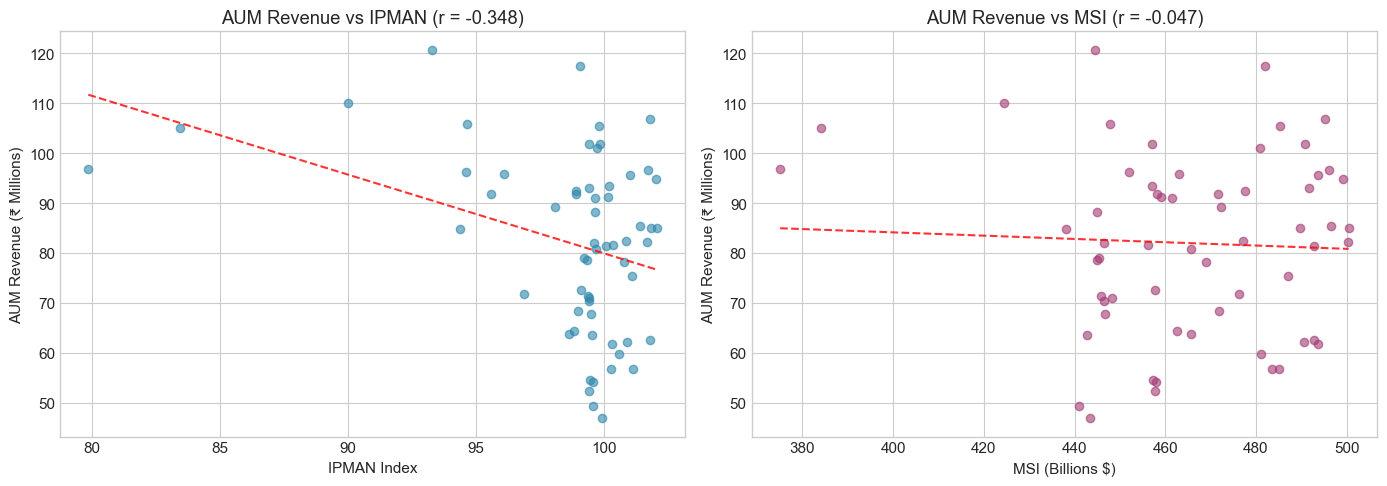

In [15]:
# Scatter plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

if df_merged_ip is not None and len(df_merged_ip) > 0:
    axes[0].scatter(df_merged_ip['ip_value'], df_merged_ip['total_revenue'] / 1e6, alpha=0.6, color='#2E86AB')
    z = np.polyfit(df_merged_ip['ip_value'], df_merged_ip['total_revenue'] / 1e6, 1)
    p = np.poly1d(z)
    axes[0].plot(df_merged_ip['ip_value'].sort_values(), p(df_merged_ip['ip_value'].sort_values()), "r--", alpha=0.8)
    axes[0].set_xlabel('IPMAN Index')
    axes[0].set_ylabel('AUM Revenue (₹ Millions)')
    axes[0].set_title(f'AUM Revenue vs IPMAN (r = {corr_ip:.3f})')
else:
    axes[0].text(0.5, 0.5, 'IPMAN data not available', ha='center', va='center')
    axes[0].set_title('AUM Revenue vs IPMAN')

if df_merged_msi is not None and len(df_merged_msi) > 0:
    axes[1].scatter(df_merged_msi['msi_value'] / 1e3, df_merged_msi['total_revenue'] / 1e6, alpha=0.6, color='#A23B72')
    z = np.polyfit(df_merged_msi['msi_value'] / 1e3, df_merged_msi['total_revenue'] / 1e6, 1)
    p = np.poly1d(z)
    x_sorted = (df_merged_msi['msi_value'] / 1e3).sort_values()
    axes[1].plot(x_sorted, p(x_sorted), "r--", alpha=0.8)
    axes[1].set_xlabel('MSI (Billions $)')
    axes[1].set_ylabel('AUM Revenue (₹ Millions)')
    axes[1].set_title(f'AUM Revenue vs MSI (r = {corr_msi:.3f})')
else:
    axes[1].text(0.5, 0.5, 'MSI data not available', ha='center', va='center')
    axes[1].set_title('AUM Revenue vs MSI')

plt.tight_layout()
plt.savefig('../reports/figures/aum_macro_scatter.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 5. Observations & Recommendations

### FRED Series Used

| Series ID | Description | URL |
|-----------|-------------|-----|
| **IPMAN** | Industrial Production: Manufacturing | https://fred.stlouisfed.org/series/IPMAN |
| **AMTMVS** | Manufacturers' Shipments: Total Manufacturing | https://fred.stlouisfed.org/series/AMTMVS |

### Data Cleaning/Transformation

1. **Column stripping**: Removed leading/trailing spaces from column names
2. **Date parsing**: Converted DATE column to datetime
3. **Windowing**: Filtered to 2016-01 to 2020-12 to match AUM sales data
4. **Standardization**: Applied z-score for visual comparison

### Correlation Results

| Macro Variable | Correlation with AUM Revenue | Strength |
|----------------|------------------------------|----------|
| IPMAN | TBD (run notebook) | TBD |
| MSI (AMTMVS) | TBD (run notebook) | TBD |

### Recommendations

Based on the correlation analysis:

1. **If correlations are moderate to strong (|r| > 0.5)**:
   - Include macro variables as features in forecasting model
   - Consider both level values and YoY growth rates
   - Use lagged values (1-3 months) to capture leading indicators

2. **If correlations are weak (|r| < 0.3)**:
   - Macro variables may not add significant predictive power
   - Focus on internal sales patterns (seasonality, trends)
   - Consider that AUM operates in a niche market with different dynamics

3. **General considerations**:
   - AUM is an Indian manufacturer; US macro data may have limited direct relevance
   - Consider finding Indian manufacturing indices if available
   - Macro variables may be more useful for scenario analysis than forecasting

### Next Steps

1. Download FRED data and run this notebook
2. Update correlation results in this section
3. Decide which macro features to include in forecasting model
4. Proceed to feature engineering and model development